In [1]:
import drawing
import numpy as np

import os

import torch 
from torch import tensor
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import matplotlib.pyplot as plt
import torch.nn.functional as F


import time

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

n_mixtures = 3
hidden_size = 900
input_size = 3
batch_size = 256
n_epochs = 1000
max_length = 1200
lr = 1e-3
model_name = "20210810_Prediction-1LSTM-3Mixtures-900Hidden-256Batch-WithoutStandarization-logSoftmax"


cuda:0


In [2]:
data_dir = "data"
data = [np.load(os.path.join(data_dir, '{}.npy'.format(i))) for i in ['x', 'x_len', 'c', 'c_len', 'w_id']]
strokes_og = data[0]
stroke_lens = data[1]
strings = data[2]
string_lens = data[3]
w_id = data[4]

In [3]:
# plt.plot(sorted(stroke_lens))
# plt.show()
# x = strokes_og[:,:,0].flatten()
# x = x[x!=0]
# x = x[x<5]
# x = x[x>-5]
# x = np.array(sorted(x))
# x.shape
# plt.plot(x)
# plt.show()
# plt.plot(np.log(x))
# plt.show()
# _=plt.hist(x, bins=100)
# plt.show()
# y = strokes_og[:,:,1].flatten()
# y = y[y!=0]
# y = y[y<5]
# y = y[y>-5]
# y = np.array(sorted(y))
# y.shape
# plt.plot(y)
# plt.show()
# plt.plot(np.log(y))
# plt.show()
# _=plt.hist(y, bins=100)

In [4]:
def standarize(strokes, lengths):
    points_to_consider = np.zeros((lengths.sum() - 2*len(lengths), 2))
    idx = 0
    for i in range(0, len(lengths)):
        #print(strokes[i][1:lengths[i], 0:2].shape)
        points_to_consider[idx:idx+lengths[i]-2] = strokes[i][1:lengths[i]-1, 0:2]
        idx += lengths[i] - 2
    means = points_to_consider.mean(axis=0)
    std = points_to_consider.std(axis=0)
    
    result = strokes.copy()
    for i in range(len(lengths)):
        result[i, 1:lengths[i]-1, 0:2] -= means
        result[i, 1:lengths[i]-1, 0:2] /= std
    return result, means, std

def destandarize(strokes_standarized, lengths, means, std):
    result = strokes_standarized.copy()
    for i in range(len(lengths)):
        result[i, 1:lengths[i]-1, 0:2] *= std
        result[i, 1:lengths[i]-1, 0:2] += means
    return result

def preprocess(strokes_og, stroke_lens, strings, string_lengths):
    # My preprocesisng is simple - all strokes start with (0, 0, 0) nd end with (0, 0, 1)

    # to this end we remove all full length strokes to make space for the end 
    # (0, 0, 1) as the end point

    indices = stroke_lens != 1200
    strokes_og = strokes_og[indices]
    stroke_lens = stroke_lens[indices]
    strings = strings[indices]
    string_lengths = string_lengths[indices]

    # Now we make sure that every stroke has the correct 
    # start point of (0, 0, 0) and end point of (0, 0, 1)
    strokes_og[:,0,2] = 0
    for i in range(strokes_og.shape[0]):
        strokes_og[i, stroke_lens[i], 2] = 1
    stroke_lens += 1
    
    # Standarize the coordinates separaetly to have zero mean and std dev 1
    # standarized_strokes, means, std = standarize(strokes_og, stroke_lens)
    
    return strokes_og, stroke_lens, strings, string_lengths



In [5]:
strokes, stroke_lengths, strings, string_lengths  = preprocess(
    strokes_og, stroke_lens, strings, string_lens)
print(strokes.shape, stroke_lengths.shape, strings.shape, string_lengths.shape)


(11846, 1200, 3) (11846,) (11846, 75) (11846,)


In [6]:
strokes[2][stroke_lengths[2]-2:stroke_lengths[2]+2]

array([[-0.9188782 , -0.29484883,  1.        ],
       [ 0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]], dtype=float32)

In [7]:
import matplotlib.pyplot as plt

def offsets_to_coords(offsets):
    """
    convert from offsets to coordinates
    """
    return np.concatenate([np.cumsum(offsets[:, :2], axis=0), offsets[:, 2:3]], axis=1)


def draw(offsets, plot_end_points=True):
    strokes = offsets_to_coords(offsets)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    stroke = []
    for x, y, eos in strokes:
        stroke.append((x, y))
        if eos == 1:
            coords = list(zip(*stroke))
            ax.plot(coords[0], coords[1], 'k')
            if plot_end_points:
                ax.plot(x, y, 'ro')
            stroke = []
    if stroke:
        coords = list(zip(*stroke))
        ax.plot(coords[0], coords[1], 'k')
        stroke = []

    padding = 10
    
    ax.set_xlim(strokes[:,0].min() - padding, strokes[:,0].max() + padding)
    ax.set_ylim(strokes[:,1].min() - padding, strokes[:,1].max() + padding)

    ax.set_aspect('equal')
    plt.tick_params(
        axis='both',
        left='off',
        top='off',
        right='off',
        bottom='off',
        labelleft='off',
        labeltop='off',
        labelright='off',
        labelbottom='off'
    )
    plt.show()
    plt.close('all')

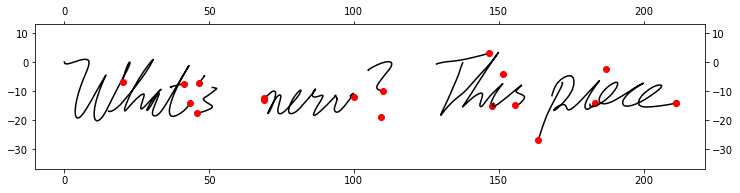

What 's new? This piece


In [8]:
draw(strokes[0])
#res2 = destandarize(strokes, stroke_lengths, means, std) # for checking
#draw(res2[0])
print(drawing.decode_ascii(strings[0]))

In [9]:
class HandwritingDataset(Dataset):
    def __init__(self, strokes, stroke_lengths):
        self.strokes = strokes
        self.stroke_lengths = stroke_lengths
        #self.mask = self.getMask()
        
    def __len__(self):
        return self.strokes.shape[0]
    
    def __getitem__(self, idx):
        return self.strokes[idx], self.stroke_lengths[idx] #, self.mask[idx]
    
    def getMask(self):
        mask = np.ones((self.strokes.shape[0], self.strokes.shape[1]))
        for i in range(self.strokes.shape[0]):
            # The mask needs to be 1 not till the last index or the index corresponding 
            # to the last character of stroke, but instead one before as the last char is 
            # always a special character (0, 0, 1) denoting the end of the stroke and 
            # we do not want to include loss computation on this as there is no point 
            # in teh stroke after this.
            mask[i][self.stroke_lengths[i]-1:] = 0
        return mask
    
train_dataset = HandwritingDataset(strokes[:10000], stroke_lens[:10000])
test_dataset = HandwritingDataset(strokes[10000:], stroke_lens[10000:])


In [10]:
class Prediction(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Prediction, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstmLayer = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linearLayer = nn.Linear(input_size+hidden_size, output_size)
        
    def forward(self, packed_input, h0, c0):
        packed_out1, (hn, cn) = self.lstmLayer(packed_input, (h0, c0))
        
        lin_layer_input = torch.cat(
            (packed_input.data, packed_out1.data), dim=-1)
        return self.linearLayer(lin_layer_input), (hn, cn)

In [11]:
def get_mixture_params_from_output(outputs):
    log_pis = F.log_softmax(outputs[:,:n_mixtures], dim=-1)
    mus = outputs[:, n_mixtures:3*n_mixtures].reshape(-1, n_mixtures, 2)
    
    sigmas = torch.exp(outputs[:, 3*n_mixtures:5*n_mixtures]).reshape(-1, n_mixtures, 2)
    phos = torch.tanh(outputs[:, 5*n_mixtures:6*n_mixtures]).reshape(-1, n_mixtures, 1)
    
    covs = torch.zeros(outputs.shape[0], n_mixtures, 2, 2, device=device)
    covs[:,:,0,0] = sigmas[:,:,0]**2
    covs[:,:,1,1] = sigmas[:,:,1]**2
    covs[:,:,0,1] = phos[:,:,0] * sigmas[:,:,0] * sigmas[:,:,1]
    covs[:,:,1,0] = covs[:,:,0,1]
    
    return log_pis, mus, covs

def get_mixture_distributions_from_output(outputs):
    log_pis, mus, covs = get_mixture_params_from_output(outputs)
    
    distributions = torch.distributions.MultivariateNormal(mus, covs)
    return log_pis, distributions

def get_pen_lift_probs_from_output(outputs):
    return 1/(1 + torch.exp(outputs[:,-1]))

def nll(outputs, targets):
    outputs = outputs.to(device)
    targets = targets.to(device)
    
    target_coords = targets[:,0:2].unsqueeze(1).repeat_interleave(
            torch.tensor([n_mixtures], device=device), dim=1)
    stroke_lift = targets[:,-1]
    
    log_pis, distributions = get_mixture_distributions_from_output(outputs)
    es = get_pen_lift_probs_from_output(outputs)

    log_probs = distributions.log_prob(target_coords)
    loss1 = - torch.logsumexp(log_pis + log_probs, dim=1)
    loss2 = - torch.log(es)*stroke_lift
    loss3 = - torch.log(1 - es)*(1-stroke_lift)
    loss_per_point = loss1 + loss2 + loss3
    
    return loss_per_point.sum()/batch_size

In [12]:
def get_next_point(model, point_prev, h_prev, c_prev):
    with torch.no_grad():
        model_input = pack_padded_sequence(
            point_prev.unsqueeze(0).unsqueeze(0),
            torch.tensor([1]).cpu().numpy(),
            batch_first=True)
        outputs, (h_next, c_next) = model(model_input, h_prev, c_prev)
        
        es = get_pen_lift_probs_from_output(outputs)
        log_pis, mus, covs = get_mixture_params_from_output(outputs)
        
        sample_index = 0
        if n_mixtures > 1:
            sample_index = np.random.choice(
                range(n_mixtures),
                p = log_pis.exp().squeeze().cpu().numpy())

        pen_off = torch.tensor(
            [np.random.binomial(1,es.item())],
            device=device)

        sample_point = torch.tensor(
            np.random.multivariate_normal(
                mus.squeeze(0)[sample_index].cpu().numpy(),
                covs.squeeze(0)[sample_index].cpu().numpy()),
            device=device)
        
        return torch.cat((sample_point, pen_off), dim=0), (h_next, c_next)
        
def sample(model):
    timestamps = max_length
    sample_stroke = torch.zeros(timestamps, 3, device=device)
    h = torch.zeros(1, 1, hidden_size, device=device)
    c = torch.zeros(1, 1, hidden_size, device=device)
    stroke_end = False
    for i in range(timestamps-2):
        prev_point = sample_stroke[i]
        new_point, (h, c) = get_next_point(model, prev_point, h, c)
        sample_stroke[i+1] = new_point
        if(new_point[0] == 0 and new_point[1] == 0 and new_point[2] == 1):
            print("Model decided to end the stroke")
            stroke_end = True
            break
    if (not stroke_end):
        sample_stroke[timestamps-1][2] = 1
    return sample_stroke

In [13]:
def get_inputs_targets_from_batch(strokes_batch, lengths_batch):
    lengths_batch, perm_idx = lengths_batch.sort(0, descending=True)
    strokes_batch = strokes_batch[perm_idx]
    
    packed_inputs = pack_padded_sequence(
        strokes_batch,
        lengths_batch.cpu().numpy() - 1, # we dont want to pack the entire sequence
        batch_first=True)
    targets = pack_padded_sequence(
        strokes_batch[:,1:,:],
        lengths_batch.cpu().numpy() - 1, # we dont want to pack the entire sequence
        batch_first=True)
    return packed_inputs, targets

def train_batch(model, optimizer, strokes_batch, lengths_batch, h0, c0):
    optimizer.zero_grad()
    inputs, targets = get_inputs_targets_from_batch(strokes_batch, lengths_batch)
    outputs, _ = model(inputs, h0, c0)
    loss = nll(outputs, targets.data)
    loss.backward()
    #### Do Gradient clipping here if need be
    optimizer.step()
    return loss.item()

def save_model(model, model_name):
    base_dir = "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/"
    torch.save({
        'model_state_dict': model.state_dict(),
    }, base_dir + model_name)
    
def train(model, optimizer, train_dataloader, num_epochs):
    losses = []
    n_iter = 0
    total_loss = 0
    start = time.time()
    
    print_every = 50
    sample_every = print_every * 5
    
    h0 = torch.zeros(1, batch_size, hidden_size, device=device)
    c0 = torch.zeros(1, batch_size, hidden_size, device=device)
    
    for epoch in range(num_epochs):
        
        for strokes_batch, lengths_batch in train_dataloader:
            strokes_batch = strokes_batch.to(device)
            lengths_batch = lengths_batch.to(device)
            
            batch_loss = train_batch(
                model,
                optimizer,
                strokes_batch,
                lengths_batch,
                h0, c0)
            h0.detach()
            c0.detach()
            total_loss += batch_loss
            
            if n_iter % print_every == 0:
                avg_loss = total_loss/print_every
                losses.append(avg_loss)
                print(f"iteration: {n_iter} "\
                      f"of {len(train_dataloader) * num_epochs}, " \
                      f"avg_loss: {avg_loss:.2f}, "\
                      f"timeSinceStart: {time.time() - start :.2f}, "\
                      f"Epoch: {epoch}")
                total_loss = 0
                save_model(model, model_name)
                
            if n_iter % sample_every == 0:
                sample_stroke = sample(model)
                # sample_stroke[1:, 0:2] *= torch.tensor(std, device=device)
                # sample_stroke[1:, 0:2] += torch.tensor(means, device=device)
                draw(sample_stroke.cpu(), plot_end_points=False)
                
            n_iter += 1
    return losses

In [14]:

model = Prediction(input_size, hidden_size, 6*n_mixtures+1).to(device)
optim = torch.optim.Adam(model.parameters(), lr = lr)
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=batch_size,
    drop_last=True)


iteration: 0 of 39000, avg_loss: 76.49, timeSinceStart: 0.85, Epoch: 0


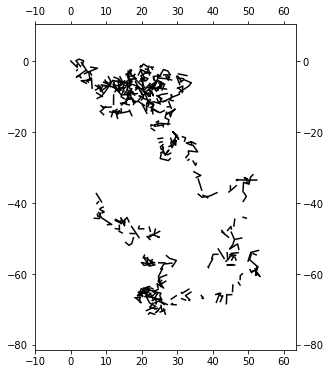

iteration: 50 of 39000, avg_loss: 1814.11, timeSinceStart: 35.01, Epoch: 1
iteration: 100 of 39000, avg_loss: 1042.87, timeSinceStart: 67.78, Epoch: 2
iteration: 150 of 39000, avg_loss: 144.85, timeSinceStart: 100.68, Epoch: 3
iteration: 200 of 39000, avg_loss: -470.77, timeSinceStart: 133.62, Epoch: 5
iteration: 250 of 39000, avg_loss: -611.35, timeSinceStart: 166.58, Epoch: 6


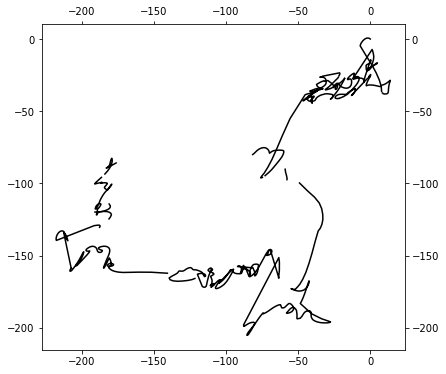

iteration: 300 of 39000, avg_loss: -690.85, timeSinceStart: 200.75, Epoch: 7
iteration: 350 of 39000, avg_loss: -795.51, timeSinceStart: 233.73, Epoch: 8
iteration: 400 of 39000, avg_loss: -684.10, timeSinceStart: 266.74, Epoch: 10
iteration: 450 of 39000, avg_loss: -616.87, timeSinceStart: 299.83, Epoch: 11
iteration: 500 of 39000, avg_loss: -821.22, timeSinceStart: 332.84, Epoch: 12


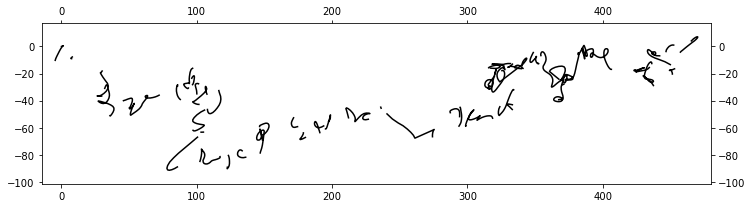

iteration: 550 of 39000, avg_loss: -776.47, timeSinceStart: 367.00, Epoch: 14
iteration: 600 of 39000, avg_loss: -879.92, timeSinceStart: 399.97, Epoch: 15
iteration: 650 of 39000, avg_loss: -846.16, timeSinceStart: 433.05, Epoch: 16
iteration: 700 of 39000, avg_loss: -847.38, timeSinceStart: 466.07, Epoch: 17
iteration: 750 of 39000, avg_loss: -890.45, timeSinceStart: 499.20, Epoch: 19


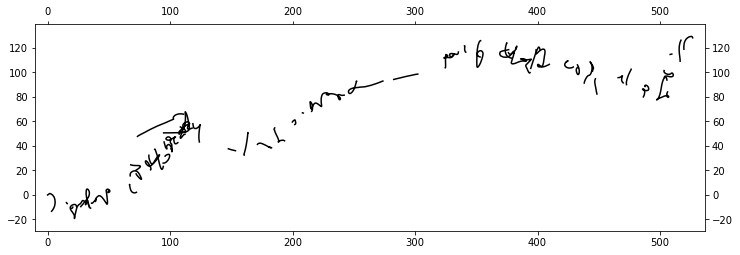

iteration: 800 of 39000, avg_loss: -693.06, timeSinceStart: 533.47, Epoch: 20
iteration: 850 of 39000, avg_loss: -835.79, timeSinceStart: 566.69, Epoch: 21
iteration: 900 of 39000, avg_loss: -884.86, timeSinceStart: 599.57, Epoch: 23
iteration: 950 of 39000, avg_loss: -1001.43, timeSinceStart: 632.75, Epoch: 24
iteration: 1000 of 39000, avg_loss: -907.99, timeSinceStart: 665.81, Epoch: 25


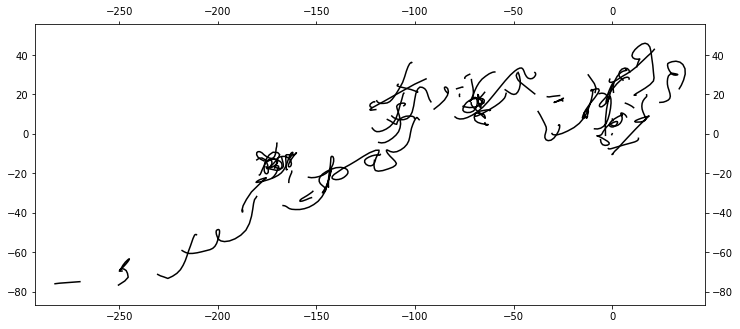

iteration: 1050 of 39000, avg_loss: -1066.57, timeSinceStart: 699.93, Epoch: 26
iteration: 1100 of 39000, avg_loss: -758.61, timeSinceStart: 732.92, Epoch: 28
iteration: 1150 of 39000, avg_loss: -912.48, timeSinceStart: 765.97, Epoch: 29
iteration: 1200 of 39000, avg_loss: -982.60, timeSinceStart: 799.00, Epoch: 30
iteration: 1250 of 39000, avg_loss: -1063.75, timeSinceStart: 832.28, Epoch: 32


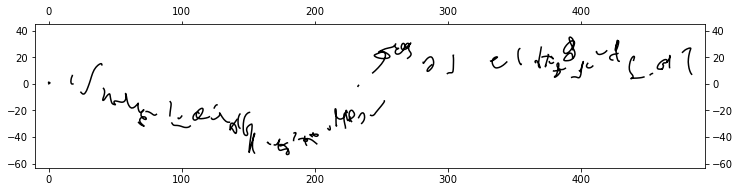

iteration: 1300 of 39000, avg_loss: -505.59, timeSinceStart: 866.50, Epoch: 33
iteration: 1350 of 39000, avg_loss: -893.77, timeSinceStart: 899.70, Epoch: 34
iteration: 1400 of 39000, avg_loss: -984.08, timeSinceStart: 932.80, Epoch: 35
iteration: 1450 of 39000, avg_loss: -998.49, timeSinceStart: 965.90, Epoch: 37
iteration: 1500 of 39000, avg_loss: -832.19, timeSinceStart: 998.95, Epoch: 38


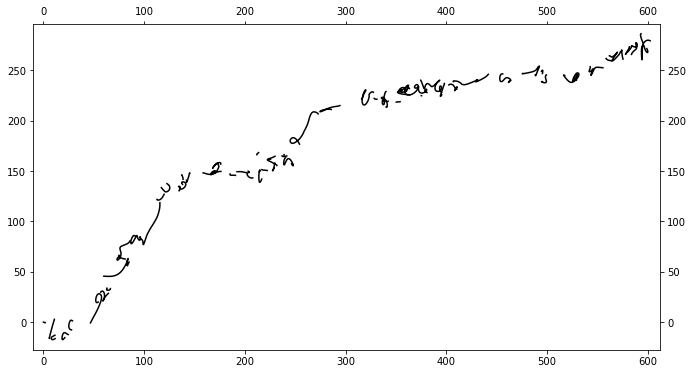

iteration: 1550 of 39000, avg_loss: -1150.96, timeSinceStart: 1033.21, Epoch: 39
iteration: 1600 of 39000, avg_loss: -933.61, timeSinceStart: 1066.22, Epoch: 41
iteration: 1650 of 39000, avg_loss: -852.81, timeSinceStart: 1099.19, Epoch: 42
iteration: 1700 of 39000, avg_loss: -1140.35, timeSinceStart: 1132.31, Epoch: 43
iteration: 1750 of 39000, avg_loss: -1053.60, timeSinceStart: 1165.29, Epoch: 44


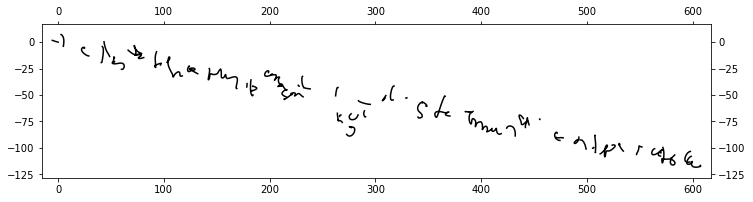

iteration: 1800 of 39000, avg_loss: -1008.25, timeSinceStart: 1199.58, Epoch: 46
iteration: 1850 of 39000, avg_loss: -521.93, timeSinceStart: 1232.56, Epoch: 47
iteration: 1900 of 39000, avg_loss: -960.26, timeSinceStart: 1265.57, Epoch: 48
iteration: 1950 of 39000, avg_loss: -1048.37, timeSinceStart: 1298.59, Epoch: 50
iteration: 2000 of 39000, avg_loss: -880.90, timeSinceStart: 1331.63, Epoch: 51


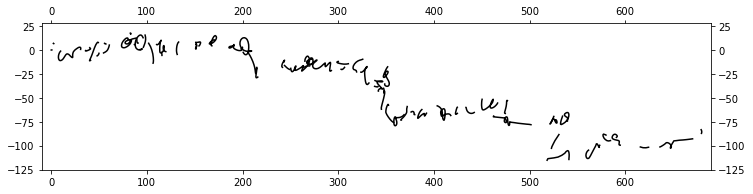

iteration: 2050 of 39000, avg_loss: -930.13, timeSinceStart: 1365.97, Epoch: 52
iteration: 2100 of 39000, avg_loss: -1165.10, timeSinceStart: 1399.01, Epoch: 53
iteration: 2150 of 39000, avg_loss: -820.12, timeSinceStart: 1432.10, Epoch: 55
iteration: 2200 of 39000, avg_loss: -1104.19, timeSinceStart: 1465.06, Epoch: 56
iteration: 2250 of 39000, avg_loss: -1258.38, timeSinceStart: 1498.22, Epoch: 57


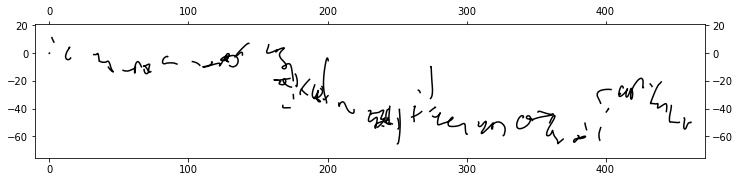

iteration: 2300 of 39000, avg_loss: -1072.87, timeSinceStart: 1532.54, Epoch: 58
iteration: 2350 of 39000, avg_loss: -948.58, timeSinceStart: 1565.89, Epoch: 60
iteration: 2400 of 39000, avg_loss: -1220.41, timeSinceStart: 1598.98, Epoch: 61
iteration: 2450 of 39000, avg_loss: -478.02, timeSinceStart: 1632.32, Epoch: 62
iteration: 2500 of 39000, avg_loss: -1020.07, timeSinceStart: 1665.99, Epoch: 64


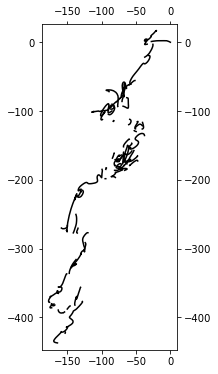

iteration: 2550 of 39000, avg_loss: -1079.26, timeSinceStart: 1700.64, Epoch: 65
iteration: 2600 of 39000, avg_loss: -840.94, timeSinceStart: 1734.13, Epoch: 66
iteration: 2650 of 39000, avg_loss: -1000.89, timeSinceStart: 1767.66, Epoch: 67
iteration: 2700 of 39000, avg_loss: -986.33, timeSinceStart: 1801.16, Epoch: 69
iteration: 2750 of 39000, avg_loss: -963.42, timeSinceStart: 1834.66, Epoch: 70


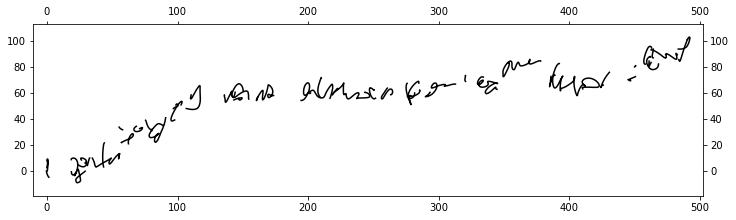

iteration: 2800 of 39000, avg_loss: -936.49, timeSinceStart: 1869.58, Epoch: 71


ValueError: Expected parameter loc (Tensor of shape (163470, 3, 2)) of distribution MultivariateNormal(loc: torch.Size([163470, 3, 2]), covariance_matrix: torch.Size([163470, 3, 2, 2])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[[nan, nan],
         [nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan],
         [nan, nan]],

        ...,

        [[nan, nan],
         [nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan],
         [nan, nan]]], device='cuda:0', grad_fn=<ExpandBackward>)

In [15]:
train(model, optim, train_dataloader, n_epochs)

In [ ]:
m = Prediction(input_size, hidden_size, 6*n_mixtures+1).to(device)

inputs = torch.randn(batch_size, max_length, input_size, device=device)
inputs[:,0, 0:3] = 0
inputs[0,4, 0:2] = 0
inputs[0,1:5, 2] = 0
inputs[0,4, 2] = 1

inputs[1,3:, 0:3] = 0
inputs[1,2, 0:2] = 0
inputs[1,2, 2] = 1
inputs[1,1, 2] = 0
inputs

lengths = torch.tensor([5, 3])

packed_inp = pack_padded_sequence(
    inputs,
    lengths.cpu().numpy() - 1, # we dont want to pack the entire sequence
    batch_first=True)
targets = pack_padded_sequence(
    inputs[:,1:,:],
    lengths.cpu().numpy() - 1, # we dont want to pack the entire sequence
    batch_first=True)
packed_inp
targets
h = torch.zeros(1, 2, 4, device=device)
out, out1 = m(packed_inp, h, h)
print("out", out)
nll(out, targets.data)
print(out1)

In [ ]:
h0 = torch.zeros(1, batch_size, hidden_size, device=device)
c0 = torch.zeros(1, batch_size, hidden_size, device=device)
print(inputs.shape, lengths.shape, lengths)
train_batch(m, optim, inputs, lengths, h0, c0)
s = sample(m)
draw(s.cpu())

In [ ]:
start = torch.tensor([0, 0, 0])


In [ ]:
inputs = torch.randn(2, 5, 3)
inputs[:,0, 0:3] = 0
inputs[0,4, 0:2] = 0
inputs[0,1:5, 2] = 0
inputs[0,4, 2] = 1

inputs[1,3:, 0:3] = 0
inputs[1,2, 0:2] = 0
inputs[1,2, 2] = 1
inputs[1,1, 2] = 0
inputs
lengths = torch.tensor([5, 3])
lengths
ps = pack_padded_sequence(
            inputs,
            lengths.cpu().numpy() - 1, # we dont want to pack the entire sequence
            batch_first=True)
lstmLayer = nn.LSTM(3, 4, batch_first=True)
linLayer = nn.Linear(4, 7)


lstmout, _ = lstmLayer(ps)
lstmout
torch.cat((ps.data,lstmout.data), dim=-1)
linLayer(lstmLayer(ps)[0][0])
pad_packed_sequence(lstmLayer(ps)[0], batch_first=True)
